**Reading PRISMA data and exporting new tiff datacube for external clipping**

In [3]:
import os
import sys
sys.path.insert(1,'./src')
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
from read_funcs import read_prs_l2d, make_rgb, make_rgb_dc,reflectance_norm,get_coord_id,append_new_line,make_rgb_aerial,band_pairing
from find_nearest import find_nearest
#from idx_mesh import idx_mesh
from img_list import prs_list
from datetime import datetime
import pathlib
from PIL import Image
import rasterio as rio
from osgeo import gdal
import h5py
import math
import geopandas as gpd

In [4]:
# Set to True to show plots, save them, and/or save processed files
make_plots = True
save = False
load = True
finished = True #if all preprocessing steps are finished, this variable is used to print aerial and PRISMA preprocessing results

In [5]:
path_l2d = "../DATABASE/"
image_path='../DATABASE/images/'
PRISMA_path="../DATABASE/PRISMA"
name='Gad161022'
name_img_prs=prs_list[name]
tstart_prs=prs_list[name][0]
tend_prs=prs_list[name][1]
filename=path_l2d+'PRS_L2D_STD_'+tstart_prs+'_'+tend_prs+'_0001'
print(tstart_prs)

20221016102331


In [4]:
#read PRISMA raw data and export it as GEOTIFF (to keep georeferenced meta data)
y, x, vwl, swl, vrf, srf, info = read_prs_l2d(path_l2d, tstart_prs, tend_prs)
print('before merge: '+str(np.shape(vrf))+str(np.shape(srf)))
wl_prs = np.append(vwl,swl)

(1218, 1263, 63) (1218, 1263, 167)
max vrf reflectance value: 0.969536

min vrf reflectance value: 0.0
converting band 1
converting band 2
converting band 3
converting band 4
converting band 5
converting band 6
converting band 7
converting band 8
converting band 9
converting band 10
converting band 11
converting band 12
converting band 13
converting band 14
converting band 15
converting band 16
converting band 17
converting band 18
converting band 19
converting band 20
converting band 21
converting band 22
converting band 23
converting band 24
converting band 25
converting band 26
converting band 27
converting band 28
converting band 29
converting band 30
converting band 31
converting band 32
converting band 33
converting band 34
converting band 35
converting band 36
converting band 37
converting band 38
converting band 39
converting band 40
converting band 41
converting band 42
converting band 43
converting band 44
converting band 45
converting band 46
converting band 47
converting ba

NameError: name 'wl_prs_reduced' is not defined

In [7]:
if save is True:
    np.save(path_l2d+'/'+name+'_wl',wl_prs)
if load:
    wl_prs=np.load(path_l2d+'/'+name+'_wl.npy')

In [8]:
#extracting the index in the vwl1 vector corresponding to R,G,B bands
R_idx_prs=find_nearest(wl_prs,640)
G_idx_prs=find_nearest(wl_prs,560)
B_idx_prs=find_nearest(wl_prs,480)

In [9]:
rgb = make_rgb_dc(vrf,vwl)
if make_plots is True:
    plt.figure(figsize=(10,10))
    """
    #uncomment if histogram stretch is needed (enhance image contrast accorsingly to the histogram of the reflectance values)
    threshold=0.7
    rgb[rgb>threshold]=threshold
    rgb=rgb/threshold
    """
    plt.imshow(rgb)

NameError: name 'vrf' is not defined

***Reading AERIAL ENVI metadata***

In [10]:
from spectral.io import envi
from spectral import *

In [8]:
aerial_path=path_l2d+'aerial/'
img = envi.open(aerial_path+"Gadertal_VI_area2.hdr",aerial_path+"Gadertal_VI_area2.dat")
print(img.metadata)

{'description': 'ENVI Spectral Index Result [Wed Mar 29 08:42:21 2023]', 'samples': '1135', 'lines': '879', 'bands': '25', 'data type': '4', 'interleave': 'bsq', 'file type': 'ENVI Standard', 'header offset': '0', 'byte order': '0', 'map info': ['UTM', '1.000', '1.000', '719180.750', '5190878.000', '2.000000e+00', '2.000000e+00', '32', 'North', 'D_WGS84', 'units=Meters'], 'coordinate system string': ['PROJCS["WGS_1984_UTM_Zone_32N"', 'GEOGCS["GCS_WGS_1984"', 'DATUM["D_WGS84"', 'SPHEROID["WGS84"', '6378137.0', '298.257223563]]', 'PRIMEM["Greenwich"', '0.0]', 'UNIT["Degree"', '0.0174532925199433]]', 'PROJECTION["Transverse_Mercator"]', 'PARAMETER["false_easting"', '500000.0]', 'PARAMETER["false_northing"', '0.0]', 'PARAMETER["central_meridian"', '9.0]', 'PARAMETER["scale_factor"', '0.9996]', 'PARAMETER["latitude_of_origin"', '0.0]', 'UNIT["Meter"', '1.0]]'], 'x start': '5435', 'y start': '6329', 'band names': ['Anthocyanin Reflectance Index 1', 'Atmospherically Resistant Vegetation Index

ImageView object:
  Display bands       :  (1, 10, 20)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-0.18597003817558289, 1.163265347480774]
    G: [-1234.199951171875, 9547.919921875]
    B: [-1.1558442115783691, 20.595745086669922]

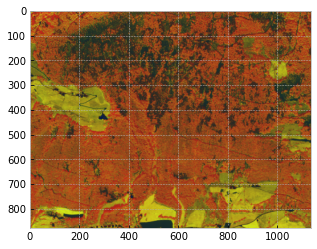

In [9]:
imshow(img, (1, 10, 20))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(230, 30, 32)
(30, 32, 230)


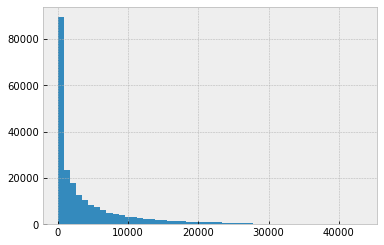

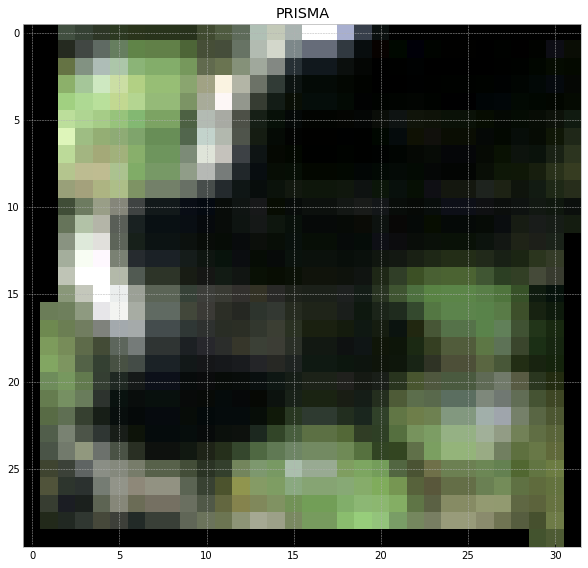

In [12]:

    src = rio.open(path_l2d+name+'_cube_coreg_intersected_area5.tif')
    prs_intersected_cube=src.read()
    src.close()
    print(np.shape(prs_intersected_cube))
    prs_intersected_cube=np.moveaxis(prs_intersected_cube,0,2)
    print(np.shape(prs_intersected_cube))
    wav=np.load(path_l2d+'/'+name+'_wl.npy')
    rgb = make_rgb_dc(prs_intersected_cube[:,:,:62],wav)
    plt.figure()
    plt.hist(prs_intersected_cube.ravel(),bins=50)
    if make_plots is True:
        plt.figure(figsize=(10,10))
        """
        #uncomment if histogram stretch is needed (enhance image contrast accorsingly to the histogram of the reflectance values)
        down_threshold=0.1
        rgb[rgb<down_threshold]=down_threshold
        rgb=rgb-down_threshold
        
        threshold=1.2
        rgb[rgb>threshold]=threshold
        rgb=rgb/threshold
        """
        plt.title('PRISMA')
        plt.imshow(rgb)



(345, 472, 500)
(472, 500, 345)
15000
1072.5593813559321


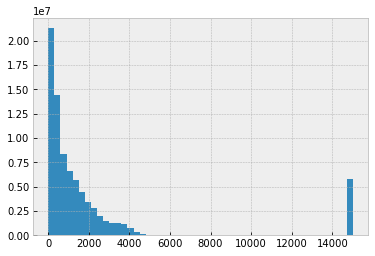

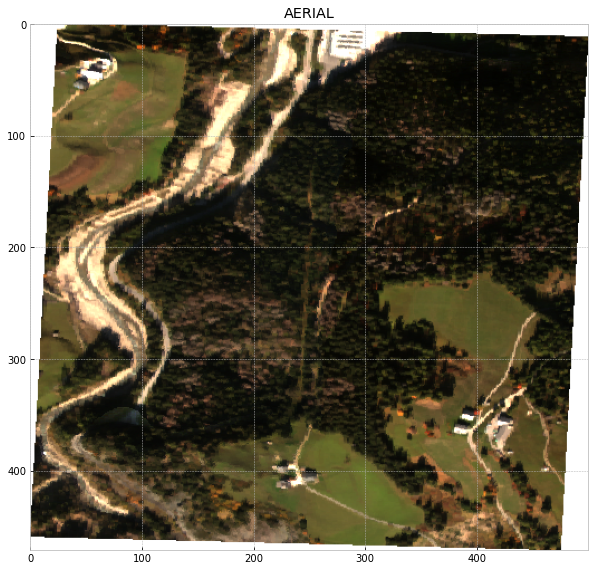

In [13]:

    src_aerial = rio.open(path_l2d+'aerial/'+'Gadertal_area5_EPSG4326.tif')
    aerial_intersected_cube=src_aerial.read()
    src_aerial.close()
    print(np.shape(aerial_intersected_cube))
    aerial_intersected_cube=np.moveaxis(aerial_intersected_cube,0,2)
    print(np.shape(aerial_intersected_cube))
    rgb_aerial = make_rgb_aerial(aerial_intersected_cube)
    plt.figure()
    plt.hist(aerial_intersected_cube.ravel(),bins=50)
    print(aerial_intersected_cube.max())
    print(aerial_intersected_cube[:,:,0].mean())
    
    if make_plots is True:
        plt.figure(figsize=(10,10))
        """
        #uncomment if histogram stretch is needed (enhance image contrast accorsingly to the histogram of the reflectance values)
        down_threshold=0
        rgb_aerial[rgb_aerial<down_threshold]=down_threshold
        rgb_aerial=rgb_aerial-down_threshold
        """
        threshold=1500
        rgb_aerial[rgb_aerial>threshold]=threshold
        rgb_aerial=rgb_aerial/threshold
        
        plt.title('AERIAL')
        plt.imshow(rgb_aerial)

In [8]:
#count pure PRISMA pixels 
df = gpd.read_file(path_l2d+'TOTAL_PIXEL_CLASS_COUNT.shp')
df.head()
pure=df[df["CLASS_COUN"]==1]
pure_count=len(pure)
total_pixels=len(df)
pure_percentage=(pure_count*100)/total_pixels
print('the percentage of monoclass pixels in the PRISMA image is: '+str(pure_percentage)+'%')

the percentage of monoclass pixels in the PRISMA image is: 29.0625%
